In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive


'Colab Notebooks'  'TF3 C3 W1 Data'   Videos_data.csv


In [3]:
import pandas as pd

# Example of reloading data
data = pd.read_csv("/content/drive/MyDrive/Videos_data.csv")  # Replace with your dataset path
data.head()


,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel


In [4]:
import pandas as pd

# Load your dataset
data = pd.read_csv("/content/drive/MyDrive/Videos_data.csv")  # Replace with the actual file path

# Combine Title and Description
data["combined_text"] = data["Title"] + " " + data["Description"]


In [5]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values if necessary
data = data.dropna(subset=["combined_text", "Category"])


Unnamed: 0         0
Video Id           0
Title              0
Description      334
Category           0
combined_text    334
dtype: int64


In [6]:
# Fill missing values in the Description column with the corresponding Title values
data.loc[data["Description"].isnull(), "Description"] = data["Title"]

# Recreate the combined_text column using the updated Description column
data["combined_text"] = data["Title"] + " " + data["Description"]

# Check for missing values again
print(data.isnull().sum())


Unnamed: 0       0
Video Id         0
Title            0
Description      0
Category         0
combined_text    0
dtype: int64


In [7]:

from sklearn.preprocessing import LabelEncoder

# Encode the Category column
label_encoder = LabelEncoder()
data["Category_encoded"] = label_encoder.fit_transform(data["Category"])

# Display the mapping
print("Category Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Category Mapping: {'art and music': 0, 'food': 1, 'history': 2, 'manufacturing': 3, 'science and technology': 4, 'travel': 5}


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    data["combined_text"],
    data["Category_encoded"],
    test_size=0.2,
    random_state=42
)

print(f"Training sentences: {len(train_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")


Training sentences: 7999
Validation sentences: 2000


In [9]:
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

# Print the model summary
model.summary()

# Ensure `train_sentences` and `val_sentences` are lists of strings
train_sentences = train_sentences.tolist() if hasattr(train_sentences, "tolist") else train_sentences
val_sentences = val_sentences.tolist() if hasattr(val_sentences, "tolist") else val_sentences

# Ensure `train_labels` and `val_labels` are lists of integers
train_labels = train_labels.tolist() if hasattr(train_labels, "tolist") else train_labels
val_labels = val_labels.tolist() if hasattr(val_labels, "tolist") else val_labels

# Preprocessing function for the dataset
def preprocess(texts, labels, tokenizer, max_len=128):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    return tf.data.Dataset.from_tensor_slices(({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }, tf.convert_to_tensor(labels)))

# Preprocess training and validation data
train_dataset = preprocess(train_sentences, train_labels, tokenizer)
val_dataset = preprocess(val_sentences, val_labels, tokenizer)

# Batch and shuffle datasets
batch_size = 16
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

# Training loop
@tf.function
def train_step(batch_inputs, batch_labels):
    with tf.GradientTape() as tape:
        predictions = model(batch_inputs, training=True).logits
        loss = loss_fn(batch_labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    metric.update_state(batch_labels, predictions)
    return loss

@tf.function
def val_step(batch_inputs, batch_labels):
    predictions = model(batch_inputs, training=False).logits
    loss = loss_fn(batch_labels, predictions)
    metric.update_state(batch_labels, predictions)
    return loss

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    # Reset metrics
    metric.reset_state()
    total_loss = 0.0

    # Training loop
    for step, (batch_inputs, batch_labels) in enumerate(train_dataset):
        loss = train_step(batch_inputs, batch_labels)
        total_loss += loss
        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss.numpy():.4f}")

    print(f"Training accuracy: {metric.result().numpy():.4f}")

    # Validation loop
    metric.reset_state()
    val_loss = 0.0
    for batch_inputs, batch_labels in val_dataset:
        loss = val_step(batch_inputs, batch_labels)
        val_loss += loss

    print(f"Validation accuracy: {metric.result().numpy():.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109486854 (417.66 MB)
Trainable params: 109486854 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/5
Step 0: Loss = 1.8318
Step 10: Loss = 1.7337
Step 20: Loss = 1.7169
Step 30: Loss = 1.4530
Step 40: Loss = 0.7970
Step 50: Loss = 0.4529
Step 60: Loss = 0.3052
Step 70: Loss = 0.1446
Step 80: Loss = 0.0920
Step 90: Loss = 0.0583
Step 100:


Epoch 1/5
Step 0: Loss = 0.0182
Step 10: Loss = 0.0008
Step 20: Loss = 0.0020
Step 30: Loss = 0.0052
Step 40: Loss = 0.0008
Step 50: Loss = 0.0029
Step 60: Loss = 0.0012
Step 70: Loss = 0.0010
Step 80: Loss = 0.0010
Step 90: Loss = 0.0020
Step 100: Loss = 0.0011
Step 110: Loss = 0.0011
Step 120: Loss = 0.0018
Step 130: Loss = 0.0008
Step 140: Loss = 0.0008
Step 150: Loss = 0.0012
Step 160: Loss = 0.0011
Step 170: Loss = 0.0009
Step 180: Loss = 0.0013
Step 190: Loss = 0.0011
Step 200: Loss = 0.2837
Step 210: Loss = 0.0015
Step 220: Loss = 0.0023
Step 230: Loss = 0.0026
Step 240: Loss = 0.0016
Step 250: Loss = 0.0012
Step 260: Loss = 0.1019
Step 270: Loss = 0.0013
Step 280: Loss = 0.0035
Step 290: Loss = 0.0038
Step 300: Loss = 0.0032
Step 310: Loss = 0.0035
Step 320: Loss = 0.0025
Step 330: Loss = 0.0017
Step 340: Loss = 0.0015
Step 350: Loss = 0.0012
Step 360: Loss = 0.0014
Step 370: Loss = 0.0012
Step 380: Loss = 0.0009
Step 390: Loss = 0.0012
Step 400: Loss = 0.0030
Step 410: Loss =

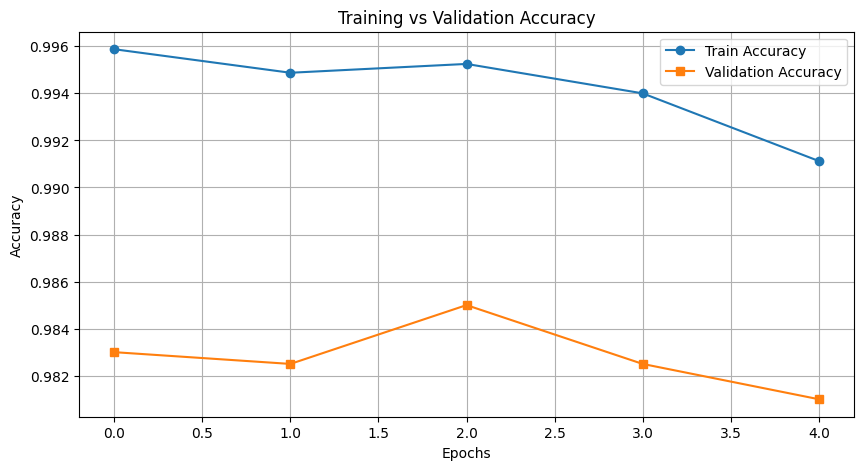

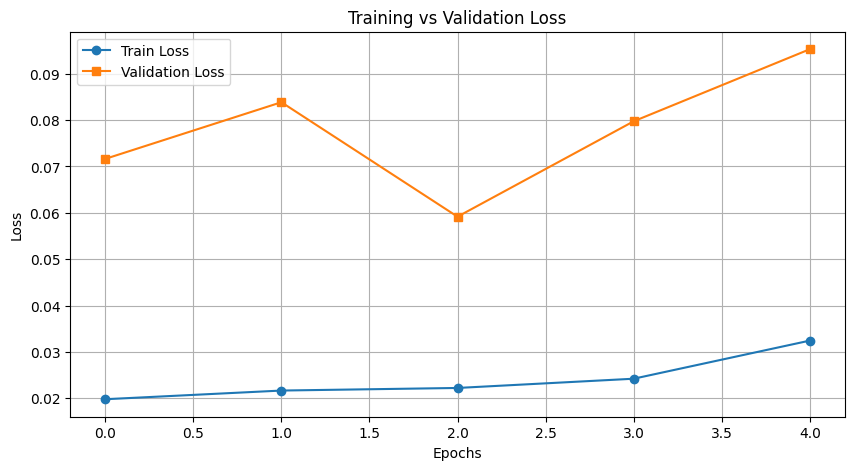

In [10]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    # Reset metrics
    metric.reset_state()
    total_loss = 0.0

    # Training loop
    for step, (batch_inputs, batch_labels) in enumerate(train_dataset):
        loss = train_step(batch_inputs, batch_labels)
        total_loss += loss
        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss.numpy():.4f}")

    train_accuracy.append(metric.result().numpy()) # Append training accuracy for current epoch
    train_loss.append(total_loss / len(train_dataset)) # Append training loss for current epoch
    print(f"Training accuracy: {train_accuracy[-1]:.4f}")

    # Validation loop
    metric.reset_state()
    val_loss_total = 0.0
    for batch_inputs, batch_labels in val_dataset:
        loss = val_step(batch_inputs, batch_labels)
        val_loss_total += loss

    val_accuracy.append(metric.result().numpy()) # Append validation accuracy for current epoch
    val_loss.append(val_loss_total / len(val_dataset)) # Append validation loss for current epoch
    print(f"Validation accuracy: {val_accuracy[-1]:.4f}")

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy', marker='o') # Use train_accuracy list
plt.plot(val_accuracy, label='Validation Accuracy', marker='s') # Use val_accuracy list
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', marker='o') # Use train_loss list
plt.plot(val_loss, label='Validation Loss', marker='s') # Use val_loss list
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming `label_encoder` is already fitted
np.save("label_classes.npy", label_encoder.classes_)
print("Label classes saved to label_classes.npy")


Label classes saved to label_classes.npy


In [12]:
# Example texts for prediction
example_texts = [
    "Fujii Kaze - Matsuri（Official Video)",
    "Egypt Travel Nightmare!! Why I’ll Never Go Back!!",
    "Breaking news: Major earthquake strikes the city",
    "Top 10 tips for better health and fitness",
    "Learn Python programming with this tutorial",
]

# Preprocess the example texts
def preprocess_for_prediction(texts, tokenizer, max_len=128):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }

# Preprocess the input texts
input_data = preprocess_for_prediction(example_texts, tokenizer)

# Make predictions
predictions = model.predict(input_data)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Display results
for text, label in zip(example_texts, predicted_labels):
    print(f"Text: {text}")
    print(f"Predicted Label: {label_encoder.inverse_transform([label])[0]}")
    print("-" * 50)


1/1 [==============================] - 3s 3s/step
Text: Fujii Kaze - Matsuri（Official Video)
Predicted Label: art and music
--------------------------------------------------
Text: Egypt Travel Nightmare!! Why I’ll Never Go Back!!
Predicted Label: travel
--------------------------------------------------
Text: Breaking news: Major earthquake strikes the city
Predicted Label: manufacturing
--------------------------------------------------
Text: Top 10 tips for better health and fitness
Predicted Label: manufacturing
--------------------------------------------------
Text: Learn Python programming with this tutorial
Predicted Label: science and technology
--------------------------------------------------


In [13]:
model.save_weights("bert_classification_weights.h5")
print("Model weights saved to bert_classification_weights.h5")


Model weights saved to bert_classification_weights.h5
